In [3]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import inv
from scipy.spatial import cKDTree

from numpy.core.umath_tests import inner1d
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
from mudata import MuData
import os.path as path
import seaborn as sns
import numexpr as ne
import pandas as pd
import scanpy as sc
import numpy as np
import muon as mu
import anndata
import h5py
import time
import umap
import gc

/tmp/4325729.1.parallel.q/ipykernel_3176/2680485318.py:15: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
data = sc.read_h5ad("./GSE194122/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [155]:
X =data.X
X_gene = X[:,data.var['feature_types']=='GEX']
X_peak = X[:,data.var['feature_types']=='ATAC']

In [156]:
X_gene.shape

(69249, 13431)

In [157]:
X_peak.shape

(69249, 116490)

In [158]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X_peak)  
#查看数据结构 tfidf[i][j]表示i类文本中的tf-idf权重  
X_peak = tfidf.toarray()

In [159]:
Agene = sc.AnnData(X_gene)
Apeak = sc.AnnData(X_peak)

In [160]:
sc.pp.filter_genes(Apeak, min_cells=100)
sc.pp.filter_genes(Agene, min_cells=100)

In [161]:
sc.pp.log1p(Agene)

In [162]:
sc.pp.log1p(Apeak)

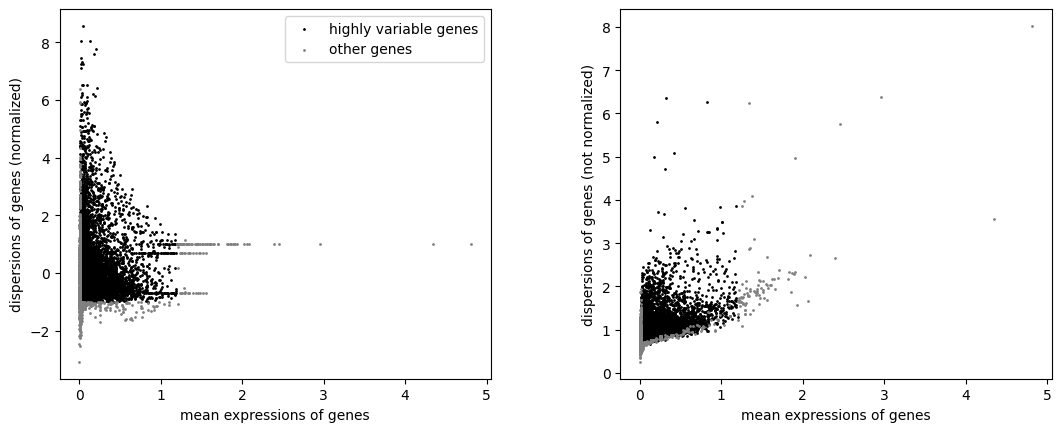

In [163]:
sc.pp.highly_variable_genes(Agene, min_mean=0.0125, max_mean=1.2, min_disp= -1,n_bins=1000)
sc.pl.highly_variable_genes(Agene)

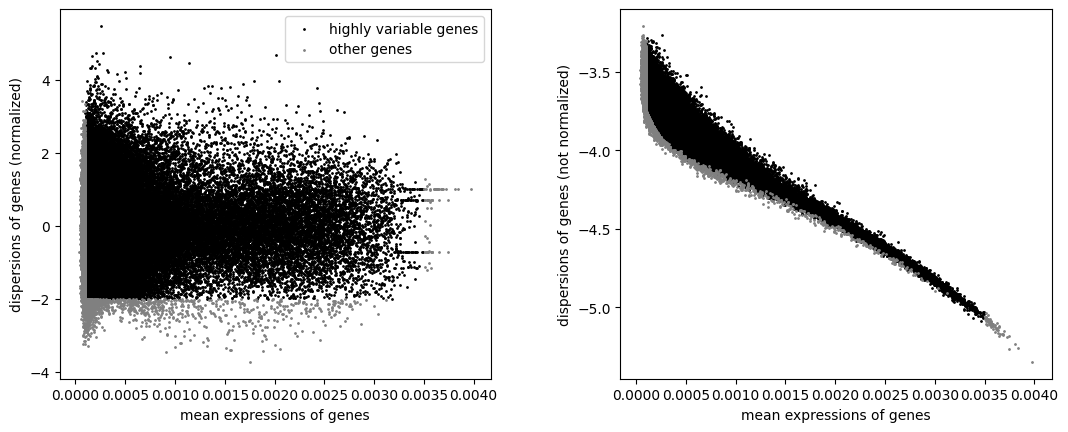

In [164]:
sc.pp.highly_variable_genes(Apeak, min_mean=0.0001, max_mean=0.0035, min_disp=-2,n_bins=1000)
sc.pl.highly_variable_genes(Apeak)

In [165]:
HVG=Agene[:,Agene.var['highly_variable']==True]
HVP=Apeak[:,Apeak.var['highly_variable']==True]

In [3]:
HVP = anndata.read_h5ad('./GSE194122/scATAC_filtered.h5ad')
HVG = anndata.read_h5ad('./GSE194122/scRNA_filtered.h5ad')

In [4]:
X_gene = HVG.X

In [6]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X_gene)  
#查看数据结构 tfidf[i][j]表示i类文本中的tf-idf权重  
X_gene = tfidf.toarray()

In [8]:
HVG.X = X_gene

In [9]:
mdata = MuData({"rna": HVG, "atac": HVP})

In [16]:
from sklearn.utils.extmath import randomized_svd

In [17]:
%%time
u_rna, s_rna, v_rna = randomized_svd(X_gene,n_components=300, random_state=0)

CPU times: user 29min 53s, sys: 8min 48s, total: 38min 41s
Wall time: 2min 43s


In [411]:
s_rna

array([95.47486458, 34.74977012, 33.06891939, 24.42013001, 19.73731989,
       18.3645173 , 15.53967841, 13.81838845, 12.64216118, 11.6244892 ,
       10.90401275, 10.31747601,  9.71396538,  8.95595868,  8.43704253,
        8.36449494,  8.02737265,  7.44866557,  7.18207639,  7.03120939,
        6.89418659,  6.76701984,  6.69817713,  6.42628136,  6.29867826,
        6.01064355,  5.90164612,  5.86202847,  5.77595047,  5.53800645,
        5.44725394,  5.36172952,  5.21422036,  5.12634256,  5.06306575,
        4.94808956,  4.90630967,  4.78415129,  4.741125  ,  4.70913099,
        4.61592357,  4.55618303,  4.54023877,  4.47783893,  4.43613729,
        4.40142571,  4.34717715,  4.33534477,  4.29723912,  4.26195308,
        4.22172303,  4.20664817,  4.16646469,  4.14028509,  4.13620509,
        4.09681722,  4.0791071 ,  4.05297426,  4.02611387,  4.00859788,
        3.98784039,  3.94148334,  3.9197111 ,  3.88508775,  3.87108689,
        3.83890677,  3.82889269,  3.81366798,  3.80437522,  3.79

In [18]:
%%time
u_atac, s_atac, v_atac = randomized_svd(X_atac,n_components=300, random_state=0)

CPU times: user 3h 10min 55s, sys: 41min 6s, total: 3h 52min 2s
Wall time: 16min 58s


## customize your own svd factorization

In [24]:
rna=[u_rna,v_rna]
atac=[u_atac,v_atac]

In [10]:
import TriTan

In [19]:
svd=[50,300,50,300]

In [346]:
tritan = TriTan.TriTan(n_component=svd,precomputed=True,svd_rna=rna,svd_atac=atac,res_size=120,resolution=10)

In [347]:
%%time
tritan.fit(mdata)

/net/scratch2/t48955xm/TriTan.py:184: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/net/scratch2/t48955xm/TriTan.py:184: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


CPU times: user 5h 14min 31s, sys: 45min 21s, total: 5h 59min 52s
Wall time: 1h 7min 46s


In [348]:
tritan.F.shape

(69249, 40)

In [349]:
mdata.obsm['X_umap']=tritan.embedding

In [356]:
group = np.argmax(tritan.F.T, axis =0)
mdata.obs['sTriTan']=[str(x) for x in group]

In [409]:
S_gene = tritan.S_gene
S_atac = tritan.S_atac
G_gene=tritan.G_gene
G_atac=tritan.G_atac

In [410]:
np.save("./GSE194122/S_gene",S_gene)
np.save("./GSE194122/S_atac",S_atac)
np.save("./GSE194122/G_atac",G_atac)
np.save("./GSE194122/G_gene",G_gene)

In [328]:
import colorcet as cc
color_list = sns.color_palette(cc.glasbey, n_colors=55)

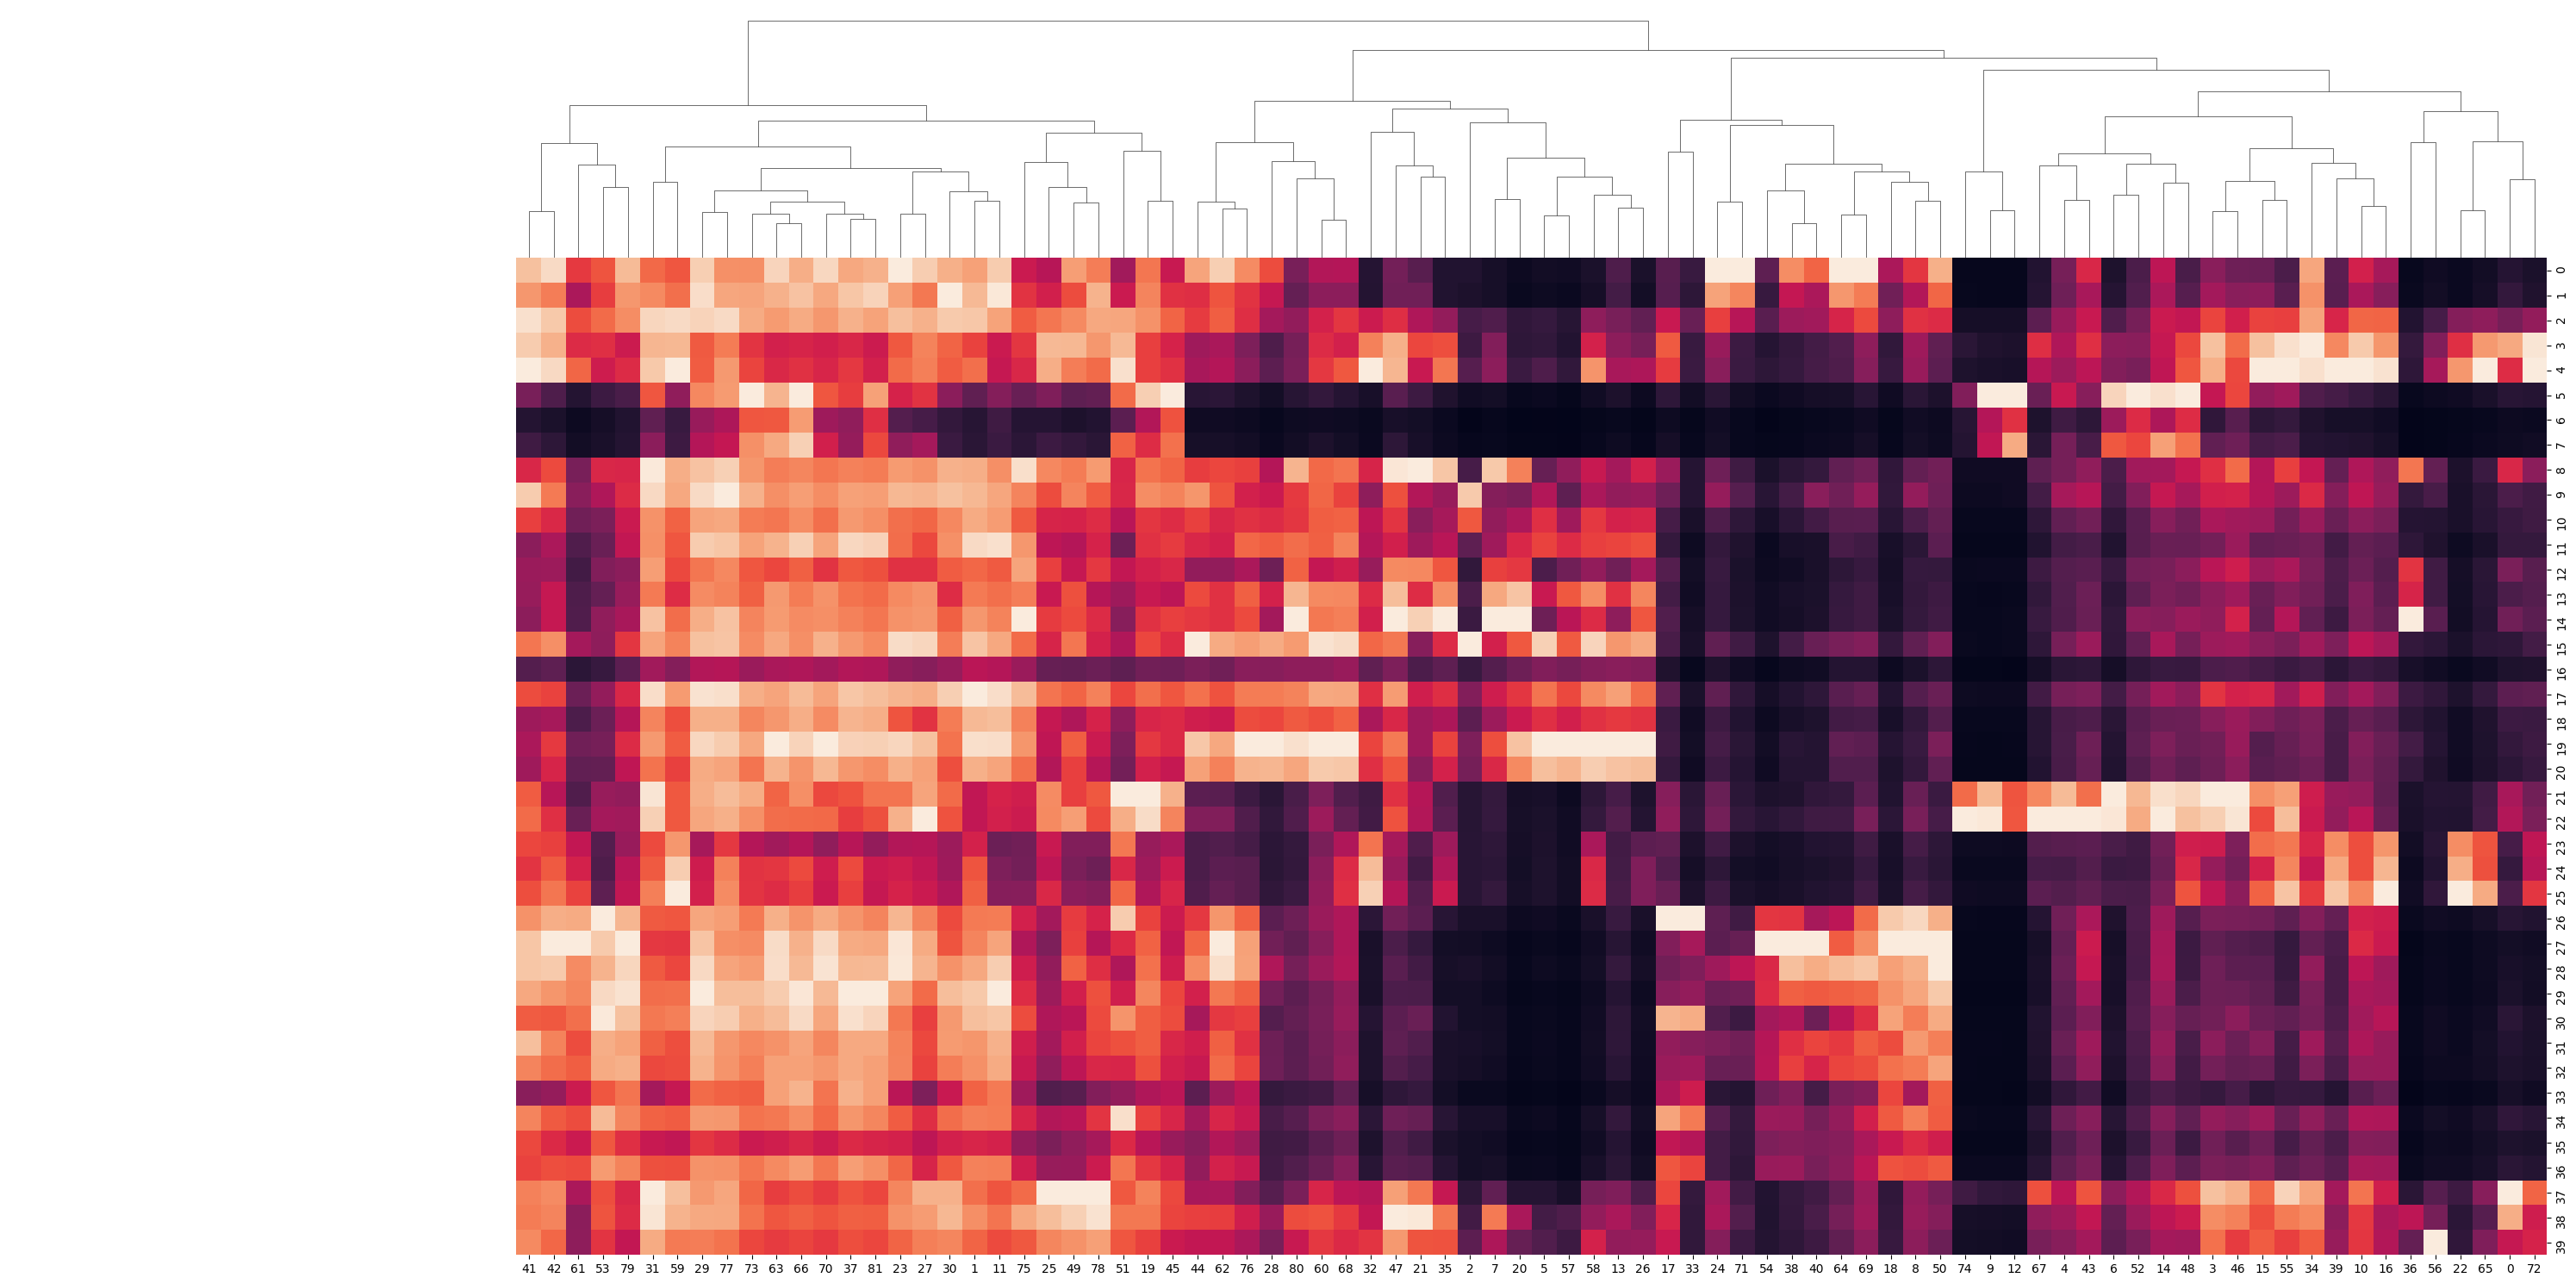

In [389]:
sns.clustermap(pd.DataFrame(normalize(S_atac, axis=0, norm='max')),figsize=(30, 15),row_cluster=False,col_cluster=True,
               cbar_pos=None)


/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


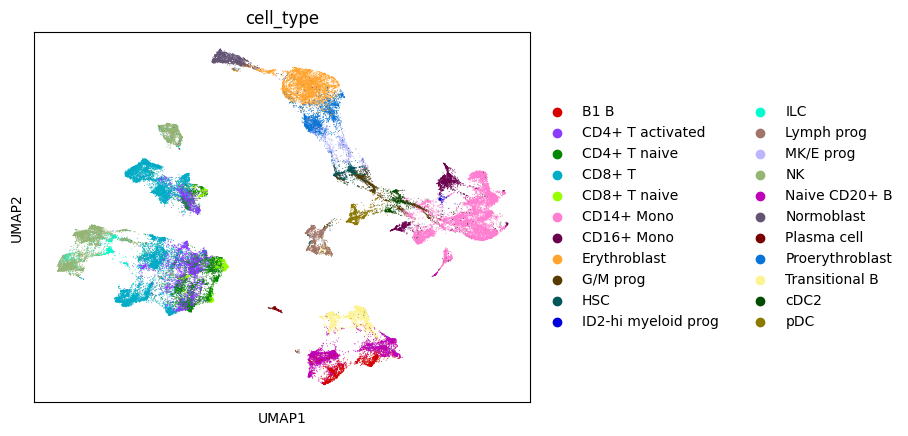

In [354]:
sc.pl.umap(mdata, color='cell_type',palette=color_list)

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


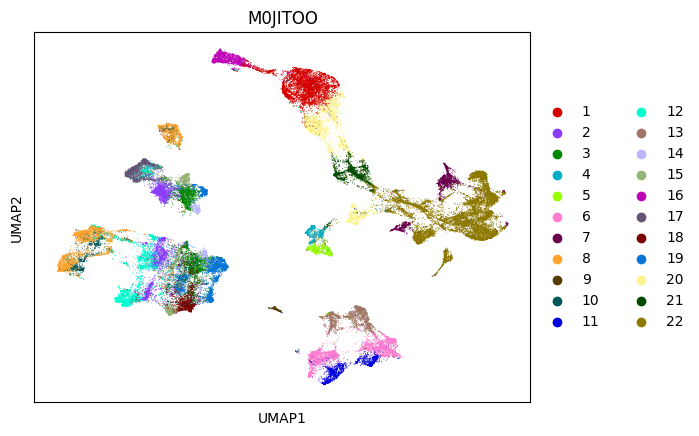

In [366]:
sc.pl.umap(mdata, color='M0JITOO',palette=color_list)

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


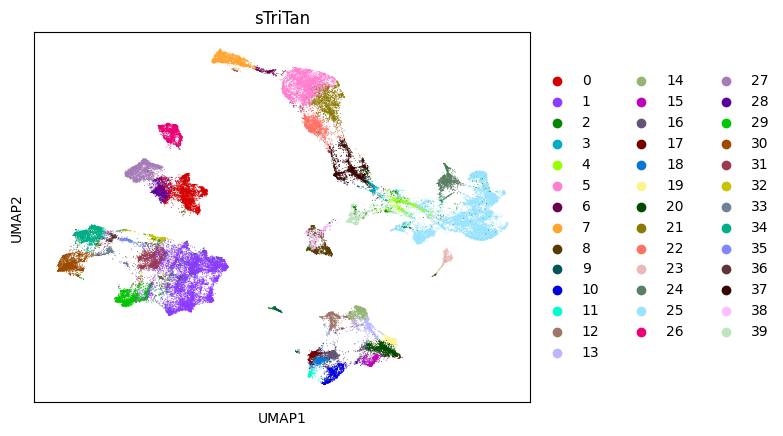

In [357]:
sc.pl.umap(mdata, color='sTriTan',palette=color_list)

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


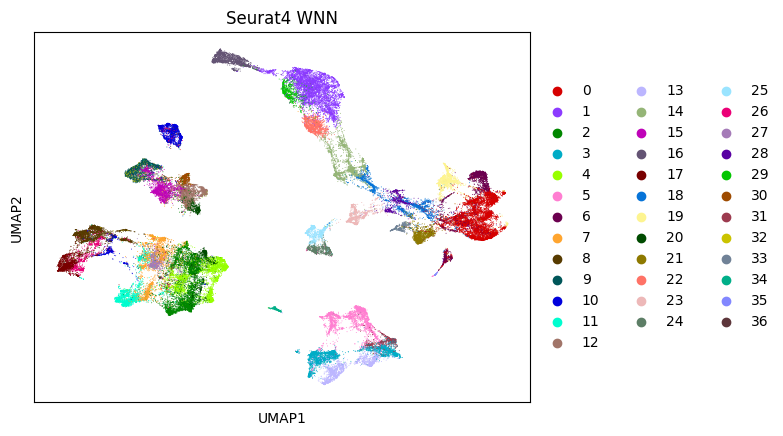

In [360]:
sc.pl.umap(mdata, color='Seurat4 WNN',palette=color_list)

In [4]:
plt.rcParams["figure.figsize"] = (2,2)

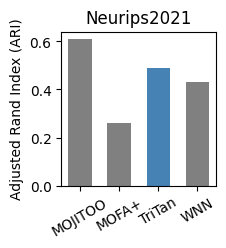

In [8]:
plt.title("Neurips2021", fontsize=12)

plt.ylabel("Adjusted Rand Index (ARI)", fontsize=10)
plt.grid(False)
x = np.array(["MOJITOO","MOFA+","TriTan","WNN"])

y = np.array([0.61,0.26,0.49,0.43])
plt.xticks(fontsize=10,rotation=30)
plt.yticks(fontsize=10)
plt.bar(x,y,color = ["grey","grey","steelblue","grey"],width = 0.6)
plt.savefig("./GSE194122/ARI.png", dpi=750, bbox_inches = 'tight')

In [358]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(mdata.obs['cell_type'],group)

0.48298925148945965

In [145]:
l=np.load('./GSE194122/MOFA_cluster.txt.npy',allow_pickle=True)

In [186]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(mdata.obs['cell_type'],l)

0.25908572591809903

In [176]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(mdata.obs['cell_type'],Mcluster)

0.6119035300252413

In [184]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(mdata.obs['cell_type'],Scluster)

0.4251681644699019

In [189]:
mdata.write("./GSE194122/GSE194122.h5mu")